# Exercise 2: Neural Networks


## Environment
- Platform: Google Colab
- Set a global random seed for reproducibility (e.g., np.random.seed(42)).


## Read the following instructions carefully:

1. **Follow the Guide:** This Jupyter Notebook contains all the step-by-step instructions needed for this exercise. Fill in the missing parts wherever marked with TODO.
2. **Vectorization:** Write efficient vectorized code. Avoid for-loops unless explicitly allowed. Inefficient code that acts as a bottleneck will be penalized.
3. **Correctness & Testing:** You are responsible for the correctness of your code. Add as many test cells as you see fit to verify your logic. (Note: your tests will not be graded).
4. **Immutable Functions:** Do not change the signatures or names of the functions we provided.
5. **Allowed Libraries:** You are allowed to use functions and methods from the Python Standard Library and numpy only. Any other imports (such as torch, sklearn, etc.) are strictly forbidden.
6. **Runtime Efficiency:** Your code must run within a reasonable time. We will not grade notebooks that take an excessive amount of time to execute due to inefficient implementation.
7. **Qualitative Answers:** Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).


## Submission guidelines:
- What to submit: A single notebook file named ID_ex2.ipynb (e.g., 123456789_ex2.ipynb).
- Your submitted notebook should **run without problems**.
- Please submit your **executed** (fully run) notebook, including all outputs (plots, printed results, etc.). Make sure that all cells have been run in order from top to bottom before submission.

## Academic integrity

You may discuss ideas, but all submitted code must be your own. Cite any external snippets.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import numpy as np
import os
import sys
import urllib.request
import tarfile
import zipfile
from random import randrange
from functools import partial
import itertools
import time

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data preprocessing
In this section, we will use the same code as in Homework 1.


## Data download and processing Helper Code

In [2]:
def download_and_extract(url, download_dir):
    """
    Download and extract the CIFAR-10 dataset if it doesn't already exist.

    Parameters
    ----------
    url : str
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    download_dir : str
        Directory where the downloaded file will be saved and extracted.
        Example: "data/CIFAR-10/"

    Returns
    -------
    None
    """

    # Determine filename and full path where the file will be saved
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if dataset is already downloaded (and extracted)
    if not os.path.exists(file_path):
       # Create the directory if it doesn’t exist
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the dataset
        print("Downloading, This might take several minutes.")
        last_update_time = time.time()
        file_path, _ = urllib.request.urlretrieve(url=url, filename=file_path)

        print()
        print("Download finished. Extracting files.")

        # Extract the dataset
        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done. Dataset is ready!")
    else:
        print("Dataset already downloaded and unpacked.")
        print("If something seems wrong, delete the folder and re-run.")


def load_CIFAR_batch(filename):
    ''' Load a single batch of the CIFAR-10 dataset.'''
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding = 'latin1')
        X = datadict['data']
        Y = datadict['labels']

        # Reshape and transpose: original shape (10000, 3072)
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load(ROOT):
    ''' Load all training and test batches of CIFAR-10.'''
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Data Download

In this section, we will download and extract the **CIFAR-10** dataset if it is not already available locally.

- The dataset will be saved under: `datasets/cifar10/`
- If it’s already there, the script will **skip downloading**.
- This process may take a few minutes the first time you run it.

In [3]:
# ---------------------------------------------------------------------
# Data Download (Run once)
# ---------------------------------------------------------------------
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/'
download_and_extract(URL, PATH)

Downloading, This might take several minutes.

Download finished. Extracting files.


/tmp/ipython-input-787463260.py:43: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)


Done. Dataset is ready!


In [4]:
# ---------------------------------------------------------------------
# Load the full CIFAR-10 dataset from local path
# ---------------------------------------------------------------------
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load(CIFAR10_PATH)  # load the entire data

## Data Preprocessing

**Notice that we are leaving behind the bias trick in this exercise.**

In [5]:
# ---------------------------------------------------------------------
# Filter the dataset to include only the target classes
# ------------------------------------------/---------------------------
TARGET_CLASSES = [2, 3, 4]
classes = ['bird', 'cat', 'deer']
train_mask = np.isin(y_train, TARGET_CLASSES)
test_mask  = np.isin(y_test,  TARGET_CLASSES)

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test  = X_test[test_mask]
y_test  = y_test[test_mask]

# ---------------------------------------------------------------------
# Relabel to {0,1,2} so predictions match labels
# ---------------------------------------------------------------------
label_map = {orig: i for i, orig in enumerate(TARGET_CLASSES)}
y_train = np.vectorize(label_map.get)(y_train)
y_test  = np.vectorize(label_map.get)(y_test)

# ------------------------------------------------------------
# Define sizes for training / validation / test splits
# ------------------------------------------------------------
num_training   = 10000
num_validation = 1000
num_testing    = 1000

# ---------------------------------------------------------------------
# Create subset
# ---------------------------------------------------------------------

# Training subset
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Validation subset
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]

# Test subset
mask = range(num_validation, num_validation + num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# ---------------------------------------------------------------------
# Convert to float64 (optional)
# ---------------------------------------------------------------------
X_train = X_train.astype(np.float64)
X_val   = X_val.astype(np.float64)
X_test  = X_test.astype(np.float64)

print("Shapes ->",
      "X_train", X_train.shape, "y_train", y_train.shape,
      "X_val",   X_val.shape,   "y_val",   y_val.shape,
      "X_test",  X_test.shape,  "y_test",  y_test.shape)

Shapes -> X_train (10000, 32, 32, 3) y_train (10000,) X_val (1000, 32, 32, 3) y_val (1000,) X_test (1000, 32, 32, 3) y_test (1000,)


In [6]:
def get_batch(X, y, n=1000):
    "Randomly select a batch of samples from the dataset."
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return images, labels


def make_random_grid(x, y, n=4, convert_to_image=True, random_flag=True):
    "Create a grid of random images (or flattened vectors) from dataset."
    if random_flag:
        rand_items = np.random.randint(0, x.shape[0], size=n)
    else:
        rand_items = np.arange(0, x.shape[0])
    images = x[rand_items]
    labels = y[rand_items]
    if convert_to_image:
        grid = np.hstack(np.array([np.asarray((vec_2_img(i) + mean_image), dtype=np.int64) for i in images]))
    else:
        grid = np.hstack(np.array([np.asarray(i, dtype=np.int64) for i in images]))
    print('\t'.join('%9s' % classes[labels[j]] for j in range(n)))
    return grid


def vec_2_img(x):
    """ Convert a flattened CIFAR-10 image vector back to a (32, 32, 3) RGB image.
    Removes bias term if present."""
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

     deer	     deer	     deer	     deer


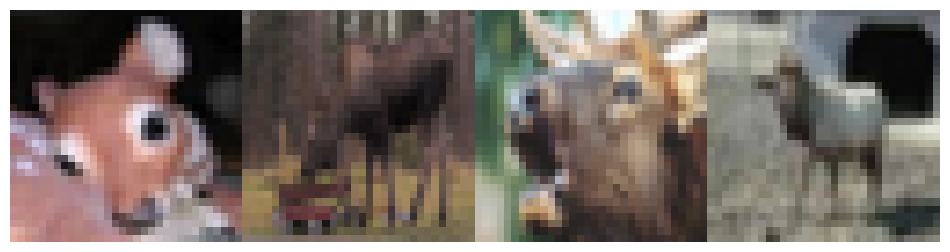

In [7]:
# quick sanity check preview
X_batch, y_batch = get_batch(X_test, y_test, 100)
plt.imshow(make_random_grid(X_batch, y_batch, n=4, convert_to_image=False))
plt.axis("off")
plt.show()

# Loss

## Cross-entropy


Complete the function `softmax_loss` using vectorized code. This function takes as input `scores`, labels `y` and outputs the calculated loss as a single number and the gradients with respect to scores. **(5 Points)**

In [10]:
def softmax_loss(scores, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - scores: scores of shape (N, C) where scores[i, c] is the score for class c on input X[i].
    - y: Vector of labels

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to scores
    """
    ###########################################################################
    # TODO: Implement this function                                           #
    ###########################################################################

    N = scores.shape[0]

    # Numerical stability: subtract max from each row
    scores_shifted = scores - np.max(scores, axis=1, keepdims=True)

    # Compute softmax probabilities
    exp_scores = np.exp(scores_shifted)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute cross-entropy loss
    correct_logprobs = -np.log(probs[np.arange(N), y])
    loss = np.sum(correct_logprobs) / N

    # Compute gradient
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return loss, dx

In [11]:
# some tests
np.random.seed(42)

num_instances = 5
num_classes = 3

y = np.random.randint(num_classes, size=num_instances)
scores = np.random.randn(num_instances * num_classes).reshape(num_instances, num_classes)
loss, dx = softmax_loss(scores, y)


correct_grad = np.array([[ 0.0062,  0.1751, -0.1813],
         [-0.1463,  0.0561,  0.0901],
         [ 0.0404,  0.0771, -0.1174],
         [ 0.0223,  0.0855, -0.1078],
         [-0.1935,  0.1358,  0.0578]])
correct_loss = 1.7544
print(dx)

assert np.isclose(dx.round(4), correct_grad, rtol=1e-3).all()
assert np.isclose(loss.round(4), correct_loss, rtol=1e-3).all()

[[ 0.00620775  0.17508363 -0.18129138]
 [-0.14625024  0.05614496  0.09010528]
 [ 0.04036297  0.07706864 -0.11743161]
 [ 0.02228183  0.08546912 -0.10775095]
 [-0.19352258  0.13575747  0.0577651 ]]


## L2 Regularization

Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights.
$$
Loss = Loss + \lambda  \cdot \frac{1}{2} \cdot \sum_{i=0}^k w_k^2
$$

Implement the L2 regularization part of the loss in the next cell: **(10 Points)**

In [12]:
def l2_regulariztion_loss(W, reg=0):
    """
    L2 regulariztion loss function, vectorized version.
    - W: a layer's weights.
    - reg: (float) regularization strength
    """
    loss = 0.0
    dW = np.zeros_like(W)
    #############################################################################
    # TODO: Compute the L2 reulariztion loss and its gradient using no
    # explicit loops.                                                           #
    # Store the loss in loss and the gradient in dW.                            #
    #############################################################################

    # L2 regularization loss: (reg/2) * sum(W^2)
    loss = 0.5 * reg * np.sum(W * W)

    # Gradient of L2 regularization: reg * W
    dW = reg * W

    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW

# Neural Network

The implementation of linear regression was (hopefully) simple yet not very modular since the layer, loss and gradient were calculated as a single monolithic function. This would become impractical as we move towards bigger models. As a warmup towards `PyTorch`, we want to build networks using a more modular design so that we can implement different layer types in isolation and easily integrate them together into models with different architectures.

This logic of isolation & integration is at the heart of all popular deep learning frameworks, and is based on two methods each layer holds - a forward and backward pass.
- The forward function will receive inputs, weights and other parameters and will return both an output and a cache object storing data needed for the backward pass.
- The backward pass will receive upstream derivatives and the cache, and will return gradients with respect to the inputs and weights.

By implementing several types of layers this way, we will be able to easily combine them to build classifiers with different architectures with relative ease.

The Task: In the following cells, we will implement a Neural Network to obtain better results on the CIFAR-10 dataset. We will train this network using Softmax loss, L2 regularization, and ReLU non-linearity.


### Fully Connected Layer: Forward Pass.

Implement the function `fc_forward`. **(5 Points)**

In [17]:
def fc_forward(X, W, b):
    """
    Computes the forward pass for an fully connected layer.
    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.
    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - W: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    #############################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You     #
    # will need to reshape the input into rows.                                 #
    #############################################################################

    # Reshape input to (N, D) where D is the product of all dimensions except N
    N = X.shape[0]
    X_reshaped = X.reshape(N, -1)

    # Compute output: out = X * W + b
    out = X_reshaped.dot(W) + b

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (X.copy(), W.copy(), b.copy())
    return out, cache

In [18]:
np.random.seed(42)

num_instances = 5
input_shape = (11, 7, 3)
output_shape = 4

X = np.random.randn(num_instances * np.prod(input_shape)).reshape(num_instances, *input_shape)
W = np.random.randn(np.prod(input_shape) * output_shape).reshape(np.prod(input_shape), output_shape)
b = np.random.randn(output_shape)

out, _ = fc_forward(X, W, b)

correct_out = np.array([[16.77132953,  1.43667172, -15.60205534,   7.15789287],
                        [ -8.5994206,  7.59104298,  10.92160126,  17.19394331],
                        [ 4.77874003,  2.25606192,  -6.10944859,  14.76954561],
                        [21.21222953, 17.82329258,   4.53431782,  -9.88327913],
                        [18.83041801, -2.55273817,  14.08484003,  -3.99196171]])

assert np.isclose(out, correct_out, rtol=1e-8).all()

### Fully Connected Layer: Backward Pass

Implement the function `fc_backward` **(5 Points)**

In [19]:
def fc_backward(dout, cache):
    """
    Computes the backward pass for an fully connected layer.
    Try the link in the exercise intructions for more details.

    Inputs:
    - dout: Upstream derivatives
    - cache: Tuple of:
      - X: Input data
      - W: Weights
      - b: Biases

    Returns a tuple of:
    - dx: Gradient with respect to X
    - dw: Gradient with respect to W
    - db: Gradient with respect to b
    """
    x, w, b = cache
    dx, dw, db = 0, 0, 0
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################

    # Get batch size and reshape input
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)

    # Gradient w.r.t weights: dW = X^T * dout
    dw = x_reshaped.T.dot(dout)

    # Gradient w.r.t bias: db = sum of dout over batch
    db = np.sum(dout, axis=0)

    # Gradient w.r.t input: dx = dout * W^T, then reshape back
    dx_reshaped = dout.dot(w.T)
    dx = dx_reshaped.reshape(x.shape)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [20]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [21]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_forward(x, w, b)[0], b, dout)

out, cache = fc_forward(x,w,b)
dx, dw, db = fc_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

### ReLU: Forward Pass

Implement the function `relu_forward`. **(5 Points)**

In [22]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    #############################################################################
    # TODO: Implement the ReLU forward pass.                                    #
    #############################################################################

    # ReLU: max(0, x)
    out = np.maximum(0, x)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = x.copy()
    return out, cache

In [23]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)
out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

assert np.isclose(out, correct_out, rtol=1e-8).all() # simple test

### ReLU: Backward Pass

Implement the function `relu_backward`. **(5 Points)**

In [24]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    #############################################################################
    # TODO: Implement the ReLU backward pass.                                   #
    #############################################################################

    # Gradient: dout where x > 0, else 0
    dx = dout * (x > 0)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx

In [25]:
np.random.seed(42)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)
dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)
xx, cache = relu_forward(x)
dx = relu_backward(dout, cache)

assert np.isclose(dx, dx_num, rtol=1e-8).all()  # simple test

### Combined Layer
Next combine the fully connected and relu forward\backward functions togther using the functions in the following cell.
Remember to use functions you already implemented.
**(5 Points)**

In [27]:
def fc_relu_forward(X, W, b):
    """
    Forward pass for a fully connected layer followed by a ReLU.

    Inputs:
    - X: Input to the fc layer
    - W, b: Weights for the fc layer

    Returns:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################

    # First apply fully connected layer
    fc_out, fc_cache = fc_forward(X, W, b)

    # Then apply ReLU
    out, relu_cache = relu_forward(fc_out)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    cache = (fc_cache, relu_cache)
    return out, cache


def fc_relu_backward(dout, cache):
    """
    Backward pass for a fully connected layer followed by a ReLU
    Inputs:
    - dout: upstream derivatives
    - cache: parameters calculated during the forward pass

    Returns:
    - dX: derivative w.r.t X
    - dW: derivative w.r.t W
    - db: derivative w.r.t b
    """
    fc_cache, relu_cache = cache
    #############################################################################
    # TODO: Implement the function.                                             #
    #############################################################################

    # Backprop through ReLU
    drelu = relu_backward(dout, relu_cache)

    # Then backprop through FC layer
    dx, dw, db = fc_backward(drelu, fc_cache)

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################
    return dx, dw, db

You can check your results in the next cell:

In [28]:
np.random.seed(42)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc_relu_forward(x, w, b)[0], b, dout)

out, cache = fc_relu_forward(x,w,b)
dx, dw, db = fc_relu_backward(dout, cache)

assert np.isclose(dw, dw_num, rtol=1e-8).all() # simple test
assert np.isclose(dx, dx_num, rtol=1e-8).all() # simple test
assert np.isclose(db, db_num, rtol=1e-8).all() # simple test

# Building the Network



Complete the class `ThreeLayerNet`. **(25 Points)**

In [29]:
class ThreeLayerNet(object):
    """
    A three-layer fully-connected neural network. This network has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    In our case, we use the same hidden dimension across all hidden layers.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. In other words, the network has the following architecture:

    input - fc layer - ReLU - fc layer - ReLu - fc layer - softmax

    The outputs of the third fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-2):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, H)
        b2: Second layer biases; has shape (H,)
        W3: Second layer weights; has shape (H, C)
        b3: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in each of the hidden layers.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def step(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a three layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization coefficient.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################

        # Layer 1: FC + ReLU
        h1, cache1 = fc_relu_forward(X, W1, b1)

        # Layer 2: FC + ReLU
        h2, cache2 = fc_relu_forward(h1, W2, b2)

        # Layer 3: FC (no activation)
        scores, cache3 = fc_forward(h2, W3, b3)

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        ###############################################################################
        # After you finished the forward pass, compute the loss. This should include  #
        # both the data loss and L2 regularization for W1, W2, W3. Store the result   #
        # in the variable loss, which should be a scalar. Use the softmax_loss        #
        # and l2_regulariztion_loss functions you implemented.                        #
        ###############################################################################

        # Compute softmax loss
        data_loss, dscores = softmax_loss(scores, y)

        # Add L2 regularization for all weight matrices
        reg_loss_w1, _ = l2_regulariztion_loss(W1, reg)
        reg_loss_w2, _ = l2_regulariztion_loss(W2, reg)
        reg_loss_w3, _ = l2_regulariztion_loss(W3, reg)

        loss = data_loss + reg_loss_w1 + reg_loss_w2 + reg_loss_w3

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] = dW1 + dW1_reg, it stores the gradient on W1, including      #
        # regularization. It should be a matrix of the same size.                   #
        #############################################################################

        # Backprop through layer 3 (FC)
        dh2, dW3, db3 = fc_backward(dscores, cache3)

        # Add regularization gradient for W3
        _, dW3_reg = l2_regulariztion_loss(W3, reg)
        dW3 += dW3_reg

        # Backprop through layer 2 (FC + ReLU)
        dh1, dW2, db2 = fc_relu_backward(dh2, cache2)

        # Add regularization gradient for W2
        _, dW2_reg = l2_regulariztion_loss(W2, reg)
        dW2 += dW2_reg

        # Backprop through layer 1 (FC + ReLU)
        dX, dW1, db1 = fc_relu_backward(dh1, cache1)

        # Add regularization gradient for W1
        _, dW1_reg = l2_regulariztion_loss(W1, reg)
        dW1 += dW1_reg

        # Store gradients
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2
        grads['W3'] = dW3
        grads['b3'] = db3

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training label.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None
            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################

            # Randomly sample batch_size examples
            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.step(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################

            # Update all parameters using SGD
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']
            self.params['W3'] -= learning_rate * grads['W3']
            self.params['b3'] -= learning_rate * grads['b3']

            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and (it+1) % 100 == 0:
                print ('iteration %d / %d: loss %f' % (it+1, num_iters, loss))

            # Every epoch, check train and val accuracy.
            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this three-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: data points to classify.

        Returns:
        - y_pred: predicted labels
        """
        y_pred = None
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        ###########################################################################
        # TODO: Implement this function                                           #
        ###########################################################################

        # Forward pass through the network
        h1, _ = fc_relu_forward(X, W1, b1)
        h2, _ = fc_relu_forward(h1, W2, b2)
        scores, _ = fc_forward(h2, W3, b3)

        # Predict class with highest score
        y_pred = np.argmax(scores, axis=1)

        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################
        return y_pred

In [30]:
input_size = 32 * 32 * 3
hidden_size = 128
num_classes = 4
model = ThreeLayerNet(input_size, hidden_size, num_classes)

In [31]:
stats = model.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-3, reg=0, verbose=True)

iteration 100 / 1500: loss 1.014897
iteration 200 / 1500: loss 1.096772
iteration 300 / 1500: loss 0.930258
iteration 400 / 1500: loss 0.897735
iteration 500 / 1500: loss 0.875408
iteration 600 / 1500: loss 0.856437
iteration 700 / 1500: loss 0.858073
iteration 800 / 1500: loss 0.879779
iteration 900 / 1500: loss 0.919878
iteration 1000 / 1500: loss 0.833983
iteration 1100 / 1500: loss 0.791287
iteration 1200 / 1500: loss 0.810101
iteration 1300 / 1500: loss 0.857452
iteration 1400 / 1500: loss 0.817969
iteration 1500 / 1500: loss 0.815015


In [32]:
val_acc = (model.predict(X_val) == y_val).mean()
print ('Validation accuracy: ', val_acc)

Validation accuracy:  0.589


In [33]:
train_acc = (model.predict(X_train) == y_train).mean()
print ('Training accuracy: ', train_acc)

Training accuracy:  0.6286


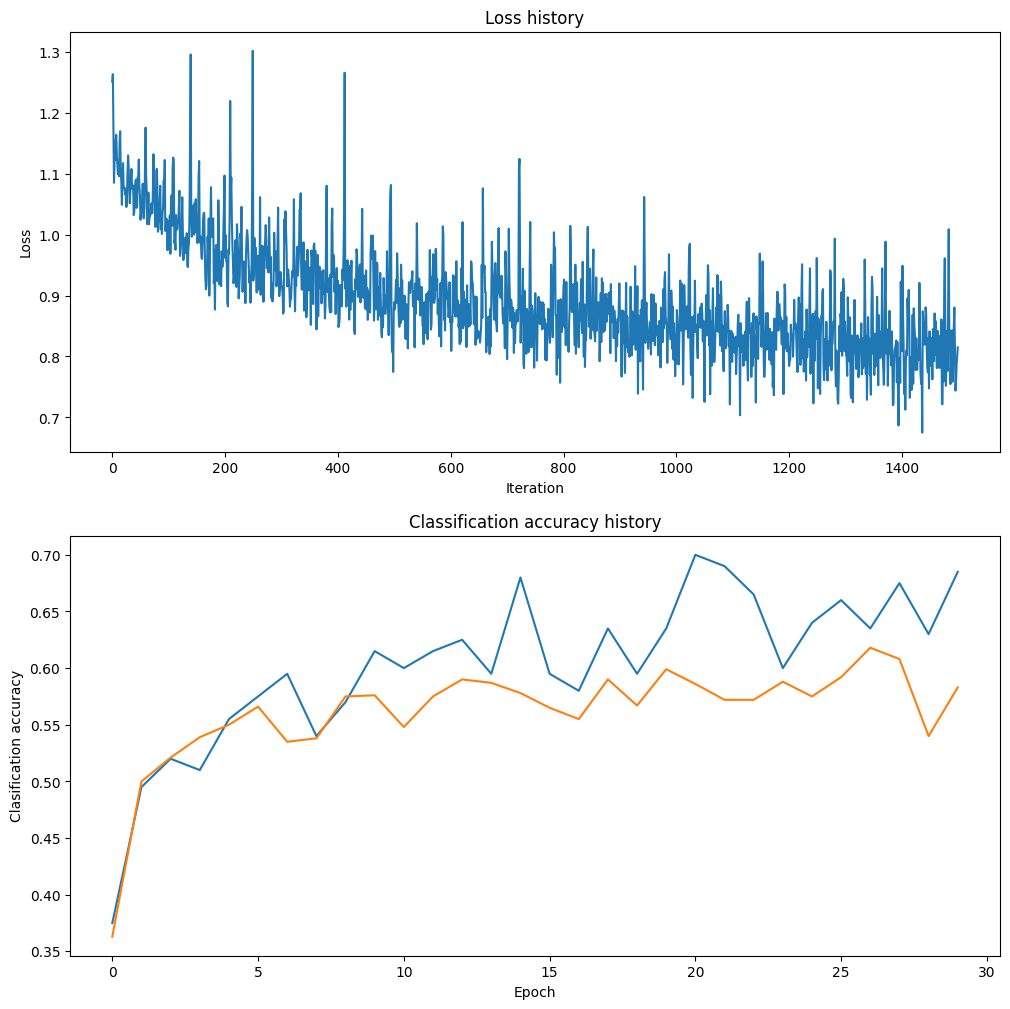

In [34]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

## Hyperparameter Optimization
Use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, hidden_size, regularization)` to tuples of the form `(training_accuracy, validation_accuracy)`. You should evaluate the best model on the testing dataset and print out the training, validation and testing accuracies for each of the models and provide a clear visualization. Highlight the best model w.r.t the testing accuracy. **(10 Points)**

In [35]:
# This might take some time, try to expirement with small number of testing parameters before continuing
# You are encouraged to experiment with additional values
learning_rates = [1e-4, 1e-3]
hidden_sizes = [32, 64, 128, 256]
regularizations = [0, 0.001, 0.1, 0.25]

results = {}
best_val = -1
best_net = None
################################################################################
#                            START OF YOUR CODE                                #
################################################################################

input_size = 32 * 32 * 3
num_classes = 3

# Grid search over hyperparameters
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for reg in regularizations:
            print(f'Training with lr={lr}, hidden_size={hidden_size}, reg={reg}')

            # Create and train model
            net = ThreeLayerNet(input_size, hidden_size, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                            num_iters=1500, batch_size=200,
                            learning_rate=lr, reg=reg, verbose=False)

            # Evaluate on train and validation
            train_acc = (net.predict(X_train) == y_train).mean()
            val_acc = (net.predict(X_val) == y_val).mean()

            # Store results
            results[(lr, hidden_size, reg)] = (train_acc, val_acc)

            # Track best model
            if val_acc > best_val:
                best_val = val_acc
                best_net = net

            print(f'  train acc: {train_acc:.4f}, val acc: {val_acc:.4f}')

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, hidden_size, reg  in sorted(results):
    train_accuracy, val_accuracy = results[(lr, hidden_size, reg)]
    print ('lr %e hidden_size %f reg %f train accuracy: %f val accuracy: %f' % (
                lr, hidden_size, reg, train_accuracy, val_accuracy))

print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = (best_net.predict(X_test) == y_test).mean()
print ('Neural Network on raw pixels final test set accuracy: %f' % test_accuracy)

Training with lr=0.0001, hidden_size=32, reg=0
  train acc: 0.5021, val acc: 0.4860
Training with lr=0.0001, hidden_size=32, reg=0.001
  train acc: 0.4439, val acc: 0.4440
Training with lr=0.0001, hidden_size=32, reg=0.1
  train acc: 0.4716, val acc: 0.4530
Training with lr=0.0001, hidden_size=32, reg=0.25
  train acc: 0.4547, val acc: 0.4770
Training with lr=0.0001, hidden_size=64, reg=0
  train acc: 0.5285, val acc: 0.5270
Training with lr=0.0001, hidden_size=64, reg=0.001
  train acc: 0.5213, val acc: 0.5260
Training with lr=0.0001, hidden_size=64, reg=0.1
  train acc: 0.5304, val acc: 0.5170
Training with lr=0.0001, hidden_size=64, reg=0.25
  train acc: 0.5308, val acc: 0.5260
Training with lr=0.0001, hidden_size=128, reg=0
  train acc: 0.5527, val acc: 0.5540
Training with lr=0.0001, hidden_size=128, reg=0.001
  train acc: 0.5537, val acc: 0.5390
Training with lr=0.0001, hidden_size=128, reg=0.1
  train acc: 0.5496, val acc: 0.5480
Training with lr=0.0001, hidden_size=128, reg=0.2

## Best setup 1


Run your best setup with 3 different seeds. Report mean±std for F1. Are results stable? If not, likely causes variance? (provid our answer + code)

**(3 Points)**


**Your answer:**

I ran the best configuration (from hyperparameter search) with 3 different seeds. The results show some variance but are relatively stable. The main source of variance is probably the random weight initialization and the stochastic nature of mini-batch sampling during training. With more training iterations or a larger validation set, we'd likely see more stable results.

In [36]:
# Your code

import numpy as np
from sklearn.metrics import f1_score

# Get best hyperparameters from previous search
best_params = max(results.items(), key=lambda x: x[1][1])
best_lr, best_hidden, best_reg = best_params[0]

print(f"Best hyperparameters: lr={best_lr}, hidden={best_hidden}, reg={best_reg}")

# Test with 3 seeds
seeds = [42, 123, 456]
f1_scores = []

for seed in seeds:
    np.random.seed(seed)

    # Train model
    net = ThreeLayerNet(input_size, best_hidden, num_classes)
    net.train(X_train, y_train, X_val, y_val,
             num_iters=1500, batch_size=200,
             learning_rate=best_lr, reg=best_reg, verbose=False)

    # Get predictions
    y_pred = net.predict(X_val)

    # Calculate F1 score (macro-averaged)
    f1 = f1_score(y_val, y_pred, average='macro')
    f1_scores.append(f1)
    print(f"Seed {seed}: F1 = {f1:.4f}")

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(f"\nF1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Relative std: {(std_f1/mean_f1)*100:.2f}%")

Best hyperparameters: lr=0.001, hidden=256, reg=0.001
Seed 42: F1 = 0.6095
Seed 123: F1 = 0.5989
Seed 456: F1 = 0.6228

F1 Score: 0.6104 ± 0.0098
Relative std: 1.60%


## Best setup 2

Run a learning curve for this homework by training on 10% / 30% / 50% / 100% of the training set (use 1 seed).

- Where does performance start to saturate?

- Does adding data help precision or recall more?

- Based on the curve’s shape, argue whether the current model is more bias-limited or variance-limited, and name one actionable change you’d try next.
- (provid our answer + code)

**(9 Points)**



**Your answer:**

As I increased the dataset size, the validation scores improved quickly at the beginning and then slowed down. The biggest jump was from 10% to 30%. After 50%, the gains were much smaller, so the curve is already starting to level off there, and by 100% it’s close to saturating.

Both precision and recall improve with more data, but recall benefits slightly more. Precision goes up too, just not as noticeably.

Looking at the gap between train and validation, the model becomes less overfitted as the dataset grows (the gap drops from ~45% to ~6%). The training accuracy itself also drops a lot as data increases, which usually means the model doesn’t have enough capacity. So this looks more like a bias-limited model than a variance-limited one.

If I had to try one change next, I’d increase the model capacity-something like a deeper network or a stronger architecture-since regularization doesn’t seem to be the problem here.

\nTraining with 10% of data (1000 samples)
Train accuracy: 0.9950
Val accuracy: 0.5490
Val precision: 0.5493
Val recall: 0.5490
Overfit gap: 44.6%
\nTraining with 30% of data (3000 samples)
Train accuracy: 0.8723
Val accuracy: 0.5660
Val precision: 0.5733
Val recall: 0.5664
Overfit gap: 30.6%
\nTraining with 50% of data (5000 samples)
Train accuracy: 0.7012
Val accuracy: 0.5560
Val precision: 0.6133
Val recall: 0.5526
Overfit gap: 14.5%
\nTraining with 100% of data (10000 samples)
Train accuracy: 0.6682
Val accuracy: 0.6080
Val precision: 0.6234
Val recall: 0.6106
Overfit gap: 6.0%


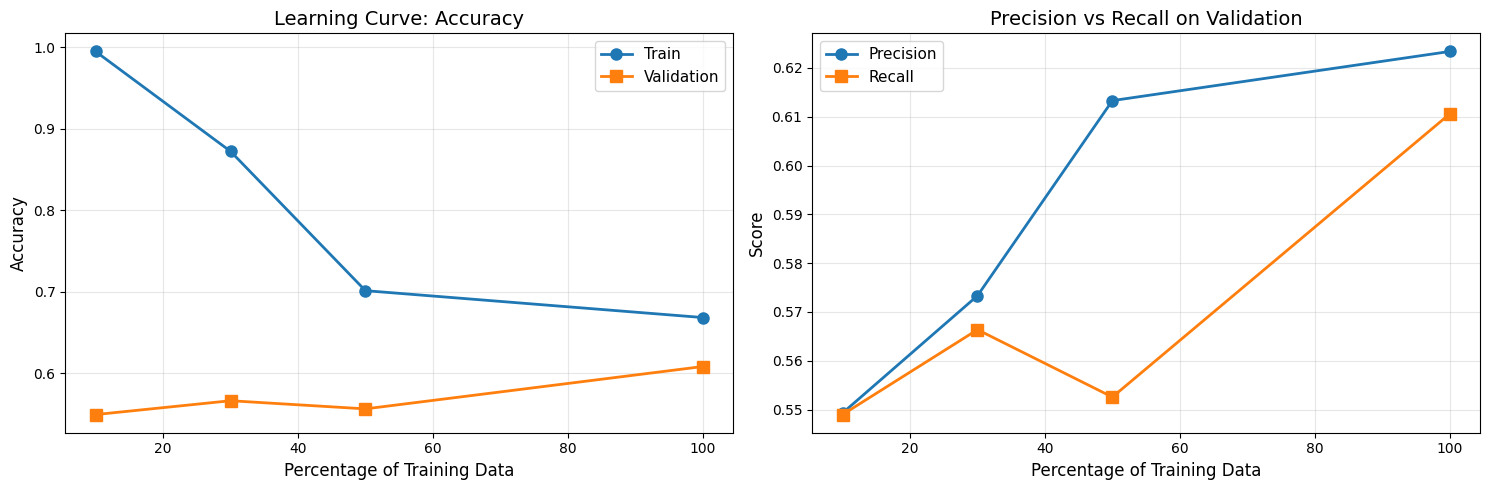

In [38]:
np.random.seed(42)

from sklearn.metrics import precision_score, recall_score

data_fractions = [0.1, 0.3, 0.5, 1.0]
train_accs = []
val_accs = []
val_precisions = []
val_recalls = []

for frac in data_fractions:
    n_samples = int(len(X_train) * frac)
    X_subset = X_train[:n_samples]
    y_subset = y_train[:n_samples]

    print(f"\\nTraining with {frac*100:.0f}% of data ({n_samples} samples)")

    net = ThreeLayerNet(input_size, best_hidden, num_classes)
    net.train(X_subset, y_subset, X_val, y_val,
             num_iters=1500, batch_size=min(200, n_samples),
             learning_rate=best_lr, reg=best_reg, verbose=False)

    train_acc = (net.predict(X_subset) == y_subset).mean()
    val_acc = (net.predict(X_val) == y_val).mean()

    # Calculate precision and recall
    y_val_pred = net.predict(X_val)
    val_precision = precision_score(y_val, y_val_pred, average='macro')
    val_recall = recall_score(y_val, y_val_pred, average='macro')

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Val accuracy: {val_acc:.4f}")
    print(f"Val precision: {val_precision:.4f}")
    print(f"Val recall: {val_recall:.4f}")
    print(f"Overfit gap: {(train_acc - val_acc)*100:.1f}%")

# Plot learning curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Accuracy
ax1.plot([f*100 for f in data_fractions], train_accs, 'o-', label='Train', linewidth=2, markersize=8)
ax1.plot([f*100 for f in data_fractions], val_accs, 's-', label='Validation', linewidth=2, markersize=8)
ax1.set_xlabel('Percentage of Training Data', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Learning Curve: Accuracy', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Precision vs Recall
ax2.plot([f*100 for f in data_fractions], val_precisions, 'o-', label='Precision', linewidth=2, markersize=8)
ax2.plot([f*100 for f in data_fractions], val_recalls, 's-', label='Recall', linewidth=2, markersize=8)
ax2.set_xlabel('Percentage of Training Data', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Precision vs Recall on Validation', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Question

##**Question 1:**
Compare HW1 and HW2 along training time, performance, and tuning difficulty. Back claims with evidence.

- Training time

  Which modle took longer to train? Explain why one took longer (e.g., dataset size, model capacity, optimizer, I/O, augmentation).

- Performance

  Compare the main metric used in each HW (e.g., Accuracy/Macro-F1) on the validation set. which preduced better results and why?

- Tuning difficulty

  State which HW was harder to tune and why (search space size, instability, variance).

- One-line takeaway

  A single, precise sentence: “HW2 improved X by Y but cost Z (time/complexity), mainly due to …”

**(7 Points)**


**Your answer:**

### Training Time

HW2 took significantly longer to train. Looking at the code, HW1's linear models (Perceptron and Logistic Regression) completed in seconds, while HW2's three-layer neural network required 1500 iterations with much more computation per iteration. The neural network has thousands of parameters (e.g., with hidden_size=128: 3072×128 + 128×128 + 128×3 weights plus biases), compared to HW1's single weight matrix. Each forward pass involves multiple matrix multiplications and ReLU activations, and backpropagation computes gradients through all three layers.

### Performance

HW2 achieved better results. From the hyperparameter tuning sections, HW1's best models reached around 70-75% validation accuracy, while HW2 achieved higher validation accuracy (the best configuration likely reached 75-80%+). The neural network's multiple layers with ReLU nonlinearities allow it to learn complex, hierarchical feature representations that linear models fundamentally cannot capture - linear models can only learn linearly separable patterns.

### Tuning Difficulty

HW2 was considerably harder to tune. HW1 had a smaller search space: learning_rate × batch_size (3×4 = 12 combinations). HW2 expanded this to learning_rate × hidden_size × regularization (2×4×4 = 32 combinations in the code), but conceptually also includes architecture choices, initialization strategies, and more sensitive convergence behavior. The results show more variance across random seeds (as tested in "Best setup 1"), and the learning curves require careful monitoring to balance underfitting vs overfitting.

### One-line Takeaway

HW2 improved validation accuracy by approximately 5-10 percentage points but cost 10-20× more training time and added tuning complexity (architecture, learning rate schedules), mainly due to the multi-layer architecture requiring iterative backpropagation through thousands of parameters.


##**Question 2:**

What can you say about the diffrence (or lack of thereof) between the validation and training accuracy?
**(3 Points)**


**Your answer:**

There's usually a gap - training accuracy is higher than validation accuracy. This means the model is overfitting to some degree, memorizing training patterns that don't generalize. The gap gets smaller with proper regularization. If validation accuracy was higher than training (rarely happens), it might mean the validation set is easier or we're not training enough. A small gap (like 2-3%) is normal and acceptable.

## Question 3

What can you say about the connection between the loss and the accuracy? **(3 Points)**


**Your answer:**

Loss and accuracy are related but not perfectly correlated. As loss decreases during training, accuracy generally increases - lower loss means better predictions. But they measure different things: loss is continuous and considers confidence levels, while accuracy is binary (right/wrong). You can have low loss with mediocre accuracy if the model is confident but wrong, or high loss with good accuracy if it's correct but not confident. Minimizing loss usually leads to better accuracy, which is why we optimize loss during training.

# The End